This notebook has the methods I developed to handle the edge effects of PWVD and instantaneous frequency profile tracking. 

--Thejasvi Beleyur 
2020-04-20

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import tftb
from tftb.processing import BertrandDistribution
import scipy.signal as signal 

from measure_horseshoe_bat_calls.simulate_calls import *
from measure_horseshoe_bat_calls.view_horseshoebat_call import visualise_call
from measure_horseshoe_bat_calls.frequency_tracking import find_above_noise_regions
import scipy.stats as stats


In [2]:
fs = 22100

Let's add some brutal white noise bursts in the middle of the chirp

In [3]:
chirp = make_fm_chirp(1000, 9000, 0.01, fs, 'hyperbolic')
chirp[50:90] += np.random.normal(0,10**(-10/20.0),40)
chirp[120:160] += np.random.normal(0,10**(-10/20.0),40)

tone = make_tone(10000, 0.005, fs)
gap = silence(0.003, fs)
linear_chirp  = make_fm_chirp(1000, 9000, 0.01, fs)
sound = np.concatenate((gap, chirp, gap, tone, gap, linear_chirp))
sound += np.random.normal(0,10**(-40/20.0), sound.size)

In [4]:
linear_chirp[10]

-0.9728226572962472

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


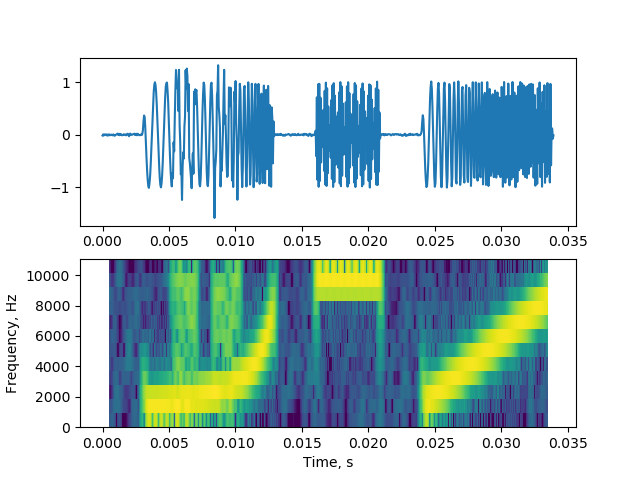

(<matplotlib.axes._subplots.AxesSubplot at 0x120de3c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x121bdb88>)

In [6]:
visualise_call(sound, fs)

In [7]:
from measure_horseshoe_bat_calls.frequency_tracking import *

In [8]:
input_signal = sound.copy()
above_noise, dbrms = find_above_noise_regions(input_signal, fs, background_noise=-10, window_size=25)

full_fp = np.zeros(input_signal.size)
for region in above_noise:    
    raw_fp, frequency_index = generate_pwvd_frequency_profile(input_signal[region],
                                                              fs, pwvd_window=0.25*10**-3,
                                                              percentile=99.9)
    full_fp[region] = raw_fp

In [9]:
log_chirp = full_fp[above_noise[0]]
cf_song = full_fp[above_noise[1]]
linear_chirp = full_fp[above_noise[2]]

<IPython.core.display.Javascript object>


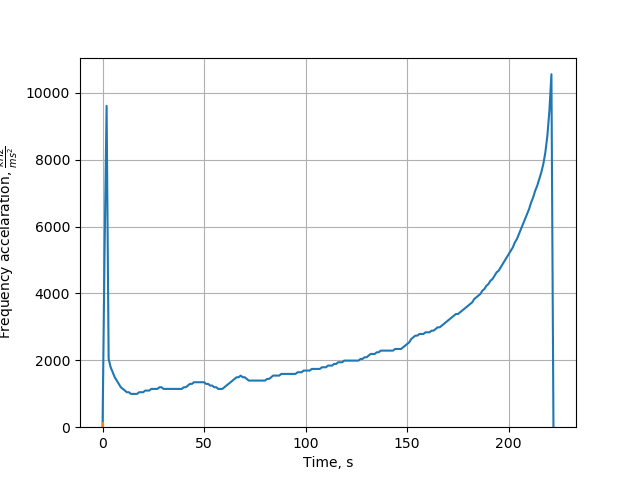

(0, 11050.0)

In [10]:
plt.figure()
plt.plot(log_chirp)
plt.grid()
plt.ylim(0,fs*0.5)

In [11]:
50/(1/22100)

1105000.0

In [12]:
def accelaration(X, fs):
    '''Calculates the accelrateion of a frequency profile in kHz/ms^2
    '''
    velocity = 10**-6*np.abs(np.gradient(X))/(1.0/fs)
    return np.abs(np.gradient(velocity))

def frequency_spike_detection(X, fs, max_acc = 0.5):
    '''Detects spikes in the frequency profile by 
    monitoring the accelration profile through the sound. 
    
    Parameters
    ----------
    X : np.array
        A frequency profile with sample-level estimates of frequency in Hz
    fs : float>0
    max_acc : float>0
        Maximum acceleration in the frequency profile. 
        Defaults to 0.5kHz/ms^2
    
    Returns
    --------
    anomalous : np.array
        Boolean 
    '''
    freq_accelaration = accelaration(X,fs)
    anomalous = freq_accelaration>max_acc
    return anomalous, freq_accelaration

def plot_accelaration_profile(X,fs):
    '''
    Plots the frequency acclearation profile of a frequency
    profile
    
    Parameters
    ----------
    X : np.array
        The frequency profile with sample-level 
        estimates of frequency in Hz. 
    fs : float>0

    Returns
    -------
    A plt.plot which can be used as an independent figure ot
    a subplot. 
    '''
    acc_profile = accelaration(X,fs)
    t = np.linspace(0,X.size/fs, X.size)
    plt.plot(t, acc_profile)
    plt.ylabel('Frequency accelaration, $\\frac{kHz}{ms^{2}}$')
    plt.xlabel('Time, s')
    

In [13]:
import scipy.signal as signal 

In [14]:
anomalous, acc  =frequency_spike_detection(log_chirp, fs, max_acc=0.3)

anom_regions, num_reg = ndimage.label(anomalous)
print(num_reg)
weird_regions = ndimage.find_objects(anom_regions)

9


In [15]:
plot_accelaration_profile(log_chirp,fs)
plt.hlines(0.29,0,0.01)

In [16]:
log_chirp[anomalous]

array([    0.        ,  5276.12612613,  9606.53153153,  2040.76576577,
        1791.89189189,  1642.56756757,  1493.24324324,  1194.59459459,
        1144.81981982,  1393.69369369,  1543.01801802,  2190.09009009,
        2339.41441441,  2687.83783784,  7416.44144144,  7615.54054054,
        7864.41441441,  8212.83783784,  8710.58558559,  9457.20720721,
       10552.25225225,     0.        ])

In [17]:
import scipy.ndimage.filters as filters

In [18]:
f0, f1 = 1000, 9000
durn = 0.01
t = np.linspace(0,durn, int(fs*durn))
actual = f0*f1*t[-1] / ((f0 - f1)*t + f1*t[-1])#f0*(f1/f0)**(t/durn)]

In [19]:
int(fs*0.25*10**-3)

5

<IPython.core.display.Javascript object>


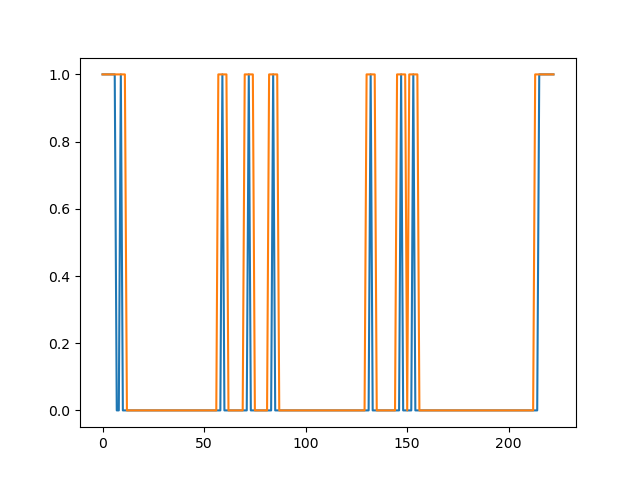

<IPython.core.display.Javascript object>


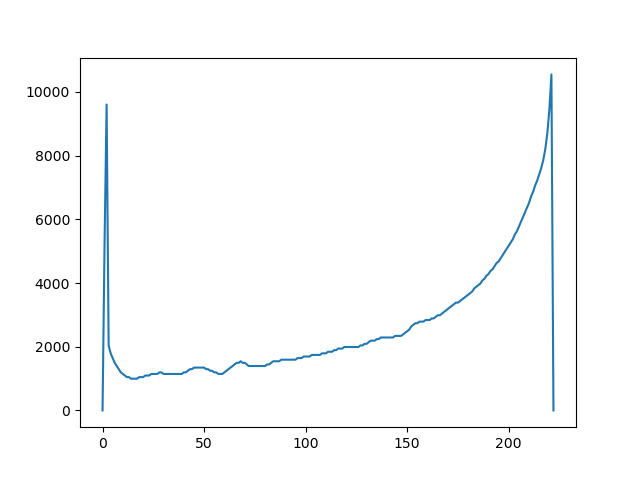

In [20]:
smoothed_bad_x = filters.percentile_filter(anomalous, 100, int(fs*0.25*10**-3))

plt.figure()
plt.plot(anomalous)
plt.plot(smoothed_bad_x)

#fit = interpolate.interp1d(good_x, good_y, kind=1, fill_value='extrapolate')

bad_x = np.argwhere(smoothed_bad_x).flatten()

#smoothed_y = fit(range(log_chirp.size))

plt.figure()
plt.plot(log_chirp)
#plt.plot(smoothed_y)
#plt.plot(actual)

<IPython.core.display.Javascript object>


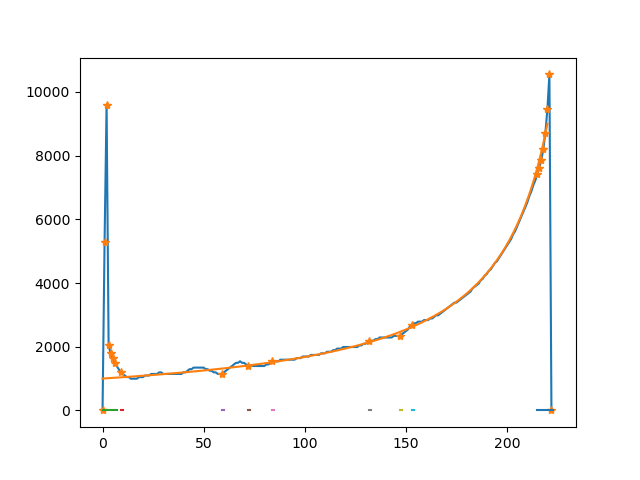

In [21]:
plt.figure()
plt.plot(log_chirp)
plt.plot(np.argwhere(anomalous).flatten(), log_chirp[anomalous], '*')
for each in weird_regions:
    plt.plot([each[0].start, each[0].stop],[1,1,])
plt.plot(actual)

In [22]:
def extrapolate_over_anomalies(X, fs, anomalous, **kwargs):
    ''' 
    Extrapolates or interpolates over every anomalous region. Anomalous regions are
    either 'edge' or 'island' types. The 'edge' anomalies are those which are 
    at the extreme ends of the signal. The 'island' anomalies are regions with 
    non-anomalous regions on the left and right. 
   
    An 'edge' anomalous region is handled by running a linear regression on the 
    neighbouring non-anomalous region, and using the slope to extrapolate over
    the edge anomaly. 
    
    An 'island' anomaly is handled by interpolating between the end values of the 
    neighbouring non-anomalous regions. 
   
    Parameters
    ----------
    X : np.array
    fs : float>0
        Sampling rate in Hz
    anomalous : np.array
        Boolean array of same size as X
        True indicates an anomalous sample. 
    extrap_window : float>0
        The duration of the extrapolation window in seconds.
        Defaults to 0.5*10^-3s

    Returns
    -------
    smooth_X : np.array
        Same size as X, with the anomalous regions 
    
    Notes
    -----
    Only extrapolation by linear regression is supported currently. The `extrap_window`
    parameter is important especially if there is a high rate of frequency modulation
    towards the edges of the sound. When there is a high freq. mod. at the edges it
    is better to set the `extrap_window` small. However, setting it too small also
    means that the extrapolation may not be as nice anymore. 

    Example
    -------
    
    Let's say there's an array with a lot of spikes in the beginning 
    >>> import scipy.ndimage as ndimage
    >>> y = np.concatenate((np.tile(100,4), np.linspace(50,55,100)))
    >>> fs = 200 # Hz
    >>> plt.figure()
    >>> plt.plot(y, label='')
    
    .....do some processing to figure out which of the samples are weird

    >>> x = np.concatenate((np.tile(0,10), np.tile(1,100)))) # the 'mock' output after processing
    >>> anomalous = ndimage.label(x)
    >>> anomalous_regions = ndimage.find_objects(anomalous)
    >>> cleaned_y = extrapolate_over_anomalies(y, fs, anomalous_regions)
    >>> plt.plot(cleaned_y)
    
    See Also
    --------
    find_closest_normal_region

    '''
    smooth_X = X.copy()
    extrap_window = kwargs.get('extrap_window', 0.5*10**-3)
    ref_region_length = int(extrap_window*fs)
    
    anomalous_broader = filters.percentile_filter(anomalous, 100, ref_region_length)
    
    anomalous_labelled, num_regions = ndimage.label(anomalous_broader)
    if num_regions == 0:
        return smooth_X

    anomalous_regions = ndimage.find_objects(anomalous_labelled)
    
    for each_region in anomalous_regions:
        region_type = anomaly_type(each_region, X)
        if region_type is 'edge':
            smooth_X[each_region] = anomaly_extrapolation(each_region, X, ref_region_length)
        elif region_type is 'island':
            smooth_X[each_region] = anomaly_interpolation(each_region, X)
    return smooth_X


def anomaly_extrapolation(region, X, num_samples):
    '''
    Takes X values next to the region and fits a linear regression 
    into the region
    
    Notes
    ------
    This function covers 90% of cases...if there is an anomaly right next
    to an edge anomaly with <num_samples distance -- of course things will
    go whack.
    '''
    start, stop = region[0].start, region[0].stop
    x = np.arange(start,stop)

    try:
        ref_x = range(stop, stop+num_samples)
        ref_range = X[ref_x]
    except:
        ref_x = range(start-num_samples, start)
        ref_range = X[ref_x]

    m, c,rv, pv, stderr = stats.linregress(ref_x, ref_range)
    extrapolated = m*x + c 
    return extrapolated

def anomaly_interpolation(region, X):
    '''
    Interpolates X values bet
    '''
    start, stop = region[0].start, region[0].stop
    left_point = start-1
    full_span = np.linspace(X[left_point],X[stop],stop-left_point+1)
    return full_span[1:-1]

def anomaly_type(region, X):
    start, stop = region[0].start, region[0].stop
    
    at_left_edge = start==0
    at_right_edge = stop==X.size
    
    if np.logical_and(at_left_edge, at_right_edge):
        raise ValueError('The anomaly spans the whole array - please check again')
    at_either_edge = np.logical_or(at_left_edge, at_right_edge)        
    
    if at_either_edge:
        return 'edge'
    else:
        return 'island'

In [23]:
log_chirp_cleaned = extrapolate_over_anomalies(log_chirp, fs,smoothed_bad_x, extrap_window=0.1*10**-3)

<IPython.core.display.Javascript object>


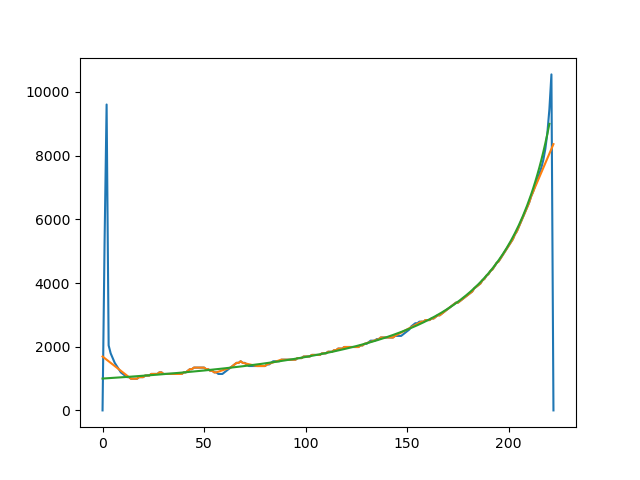

In [24]:
plt.figure()
plt.plot(log_chirp)
plt.plot(log_chirp_cleaned)
plt.plot(actual)


In [25]:
from tftb.processing import inst_freq

In [26]:
freqs, _ = inst_freq(signal.hilbert(input_signal[above_noise[0]]))

In [27]:
anomalous, acc  =frequency_spike_detection(freqs*fs, fs, max_acc=5)
cleaned_fp = extrapolate_over_anomalies(freqs*fs, fs, anomalous, extrap_window=0.5*10**-3)

<IPython.core.display.Javascript object>


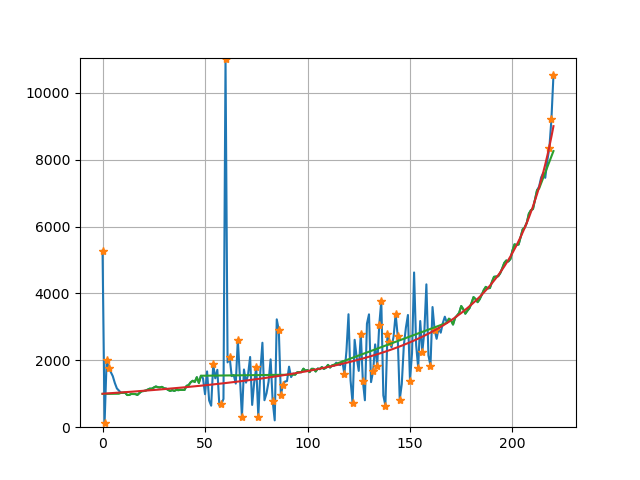

(0, 11050.0)

In [28]:
plt.figure()
plt.plot(freqs*fs)
plt.plot(np.argwhere(anomalous).flatten(), freqs[anomalous]*fs, '*')
plt.plot(cleaned_fp)
plt.plot(actual)
plt.grid()
plt.ylim(0,fs*0.5)

In [29]:
import datetime as dt
print('This notebook was last run from top to bottom: ',dt.datetime.now())

This notebook was last run from top to bottom:  2020-04-20 19:28:10.486971
